In [20]:
def visualize_nn_from_csv_colored(
    csv_path,
    max_nodes_per_layer=12,
    max_connections=150,
    layer_activations=None,
    label_y_offset=0.05
):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from ast import literal_eval

    df = pd.read_csv(csv_path)
    df["shape"] = df["shape"].apply(lambda x: literal_eval(x))
    kernel_rows = df[df["shape"].apply(lambda s: len(s) == 2)].reset_index(drop=True)

    kernel_mats = []
    layer_sizes = []

    for idx, row in kernel_rows.iterrows():
        shape = row["shape"]
        vals = np.array(literal_eval(row["values"]), dtype=float)
        W = vals.reshape(shape)
        kernel_mats.append(W)
        in_dim, out_dim = shape
        if idx == 0:
            layer_sizes.append(in_dim)
        layer_sizes.append(out_dim)

    n_non_input = len(layer_sizes) - 1

    if layer_activations is None:
        layer_activations = ["ReLU"] * (n_non_input - 1) + ["Sigmoid"]
    else:
        if len(layer_activations) != n_non_input:
            raise ValueError("layer_activations length mismatch.")

    layer_labels = ["Input (" + str(layer_sizes[0]) + ")"]
    for i in range(1, len(layer_sizes)):
        out_dim = layer_sizes[i]
        act = layer_activations[i - 1]
        lbl = "Output" if i == len(layer_sizes) - 1 else "Dense"
        layer_labels.append(f"{lbl} ({out_dim})\n{act}")

    n_layers = len(layer_sizes)
    x_spacing = 1.0 / (n_layers - 1)

    fig, ax = plt.subplots(figsize=(12, 6))
    node_positions = []

    layer_colors = []
    for lbl in layer_labels:
        if lbl.startswith("Input"):
            layer_colors.append("#1f77b4")
        elif lbl.startswith("Output"):
            layer_colors.append("#d62728")
        else:
            layer_colors.append("#2ca02c")

    for i, (size, name) in enumerate(zip(layer_sizes, layer_labels)):
        draw_count = min(size, max_nodes_per_layer)
        ys = np.linspace(0.1, 0.9, draw_count)
        x = i * x_spacing
        color = layer_colors[i]

        nodes = []
        for y in ys:
            c = plt.Circle((x, y), 0.02, edgecolor="black", facecolor=color, alpha=0.9)
            ax.add_patch(c)
            nodes.append((x, y))
        node_positions.append(nodes)

        ax.text(
            x,
            1.0 + label_y_offset,
            f"{name}\n(full: {size})",
            ha="center",
            va="center",
            fontsize=10,
        )

    rng = np.random.default_rng(42)

    for l in range(len(kernel_mats)):
        W = kernel_mats[l]
        absW = np.abs(W)
        w_min, w_max = absW.min(), absW.max()

        from_nodes = node_positions[l]
        to_nodes = node_positions[l + 1]

        fs = layer_sizes[l]
        ts = layer_sizes[l + 1]

        fd = len(from_nodes)
        td = len(to_nodes)

        if fs <= fd:
            fi = np.arange(fs)
        else:
            fi = np.linspace(0, fs - 1, fd, dtype=int)

        if ts <= td:
            ti = np.arange(ts)
        else:
            ti = np.linspace(0, ts - 1, td, dtype=int)

        pairs = []
        for fij, (x1, y1) in zip(fi, from_nodes):
            for tjj, (x2, y2) in zip(ti, to_nodes):
                pairs.append(((x1, y1, fij), (x2, y2, tjj)))

        if len(pairs) > max_connections:
            pairs = rng.choice(pairs, size=max_connections, replace=False)

        for (x1, y1, fij), (x2, y2, tjj) in pairs:
            s = absW[fij, tjj]
            lw = 0.3 if w_max == w_min else 0.3 + (s - w_min) / (w_max - w_min) * (3.0 - 0.3)
            ax.plot([x1, x2], [y1, y2], linewidth=lw, color="gray", alpha=0.7)

    ax.set_title("Neural Network (Colored, Weight-Scaled, Activation Labels)", fontsize=15)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(0, 1.05 + label_y_offset)
    plt.tight_layout()
    plt.show()


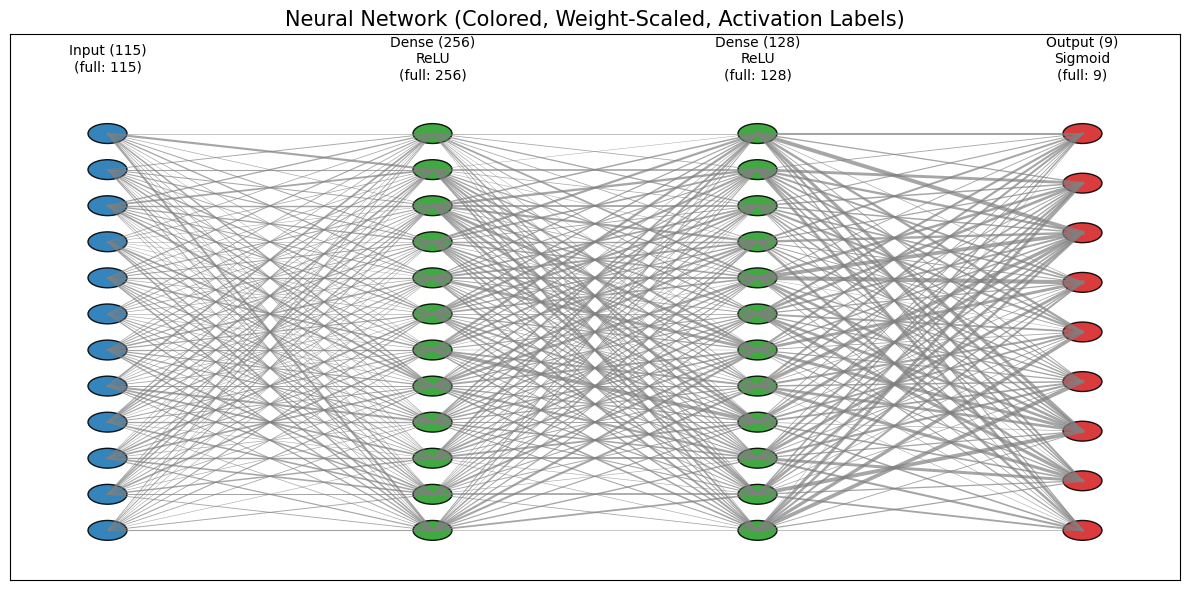

In [21]:
visualize_nn_from_csv_colored("model_weights.csv")
